# Twitter data exploration to reveal ideas and author underlying relations


In [1]:
import pickle
#import os
#from collections import Counter
#import json
#import datetime as dt
import twitter
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

In [2]:
Twitter=pickle.load(open('secret_twitter_credentials.pkl','rb'))

In [3]:
#!pip install twitter

# Twitter data collection


## Authorizing an application to access Twitter account data

In [4]:
auth = twitter.oauth.OAuth(Twitter['Access Token'],
                           Twitter['Access Token Secret'],
                           Twitter['Consumer Key'],
                           Twitter['Consumer Secret'])

twitter_api = twitter.Twitter(auth=auth, retry=True)

## Collecting results in a sqlite database

In [5]:
conn = sqlite3.connect('tweets.db')
c = conn.cursor()

# Create base
#------------------------------------------------------------
# Table: statuses
#------------------------------------------------------------
c.execute('''CREATE TABLE statuses(
        id                    Int NOT NULL ,
        coordinates           Varchar (250) ,
        created_at            Varchar (250) ,
        favorite_count        Int ,
        lang                  Varchar (25) ,
        place                 Varchar (2500) ,
        scopes                Varchar (2500) ,
        retweet_count         Int ,
        source                Varchar (2500) ,
        txt                   Varchar (250) ,
        withheld_in_countries Varchar (250) ,
        retweeted_status_id   Int ,
        in_reply_to_status_id Int ,
        in_reply_to_user_id   Int,
        quoted_status_id      Int ,
        user_id               Int ,
        PRIMARY KEY (id )
        );''')

#------------------------------------------------------------
# Table: users
#------------------------------------------------------------
c.execute('''CREATE TABLE users(
        id                    Int NOT NULL ,
        screen_name           Varchar (250) ,
        created_at            Varchar (100) ,
        description           Varchar (2500) ,
        favourites_count      Int ,
        followers_count       Int ,
        friends_count         Int ,
        lang                  Varchar (25) ,
        listed_count          Int ,
        location              Varchar (250) ,
        name                  Varchar (25) ,
        statuses_count        Int ,
        PRIMARY KEY (id )
        );''')

#------------------------------------------------------------
# Table: mentions
#------------------------------------------------------------

c.execute('''CREATE TABLE mentions(
        status_id Int NOT NULL ,
        user_id Int NOT NULL ,
        PRIMARY KEY (status_id ,user_id )
);''')

#------------------------------------------------------------
# Table: tags
#------------------------------------------------------------

c.execute('''CREATE TABLE tags(
        status_id Int NOT NULL ,
        htg    Varchar (140) NOT NULL ,
        PRIMARY KEY (status_id ,htg )
);''')

## Alter tables to differenciate elements directly linked to neonics
c.execute("ALTER TABLE statuses ADD linked_neonics INTEGER")
c.execute("UPDATE statuses SET linked_neonics=1")



c.execute("ALTER TABLE users ADD linked_neonics INTEGER")
c.execute("UPDATE users SET linked_neonics=1")

In [26]:
c.execute('''PRAGMA table_info(users);''').fetchall()

[(0, 'id', 'Int', 1, None, 1),
 (1, 'screen_name', 'Varchar (250)', 0, None, 0),
 (2, 'created_at', 'Varchar (100)', 0, None, 0),
 (3, 'description', 'Varchar (2500)', 0, None, 0),
 (4, 'favourites_count', 'Int', 0, None, 0),
 (5, 'followers_count', 'Int', 0, None, 0),
 (6, 'friends_count', 'Int', 0, None, 0),
 (7, 'lang', 'Varchar (25)', 0, None, 0),
 (8, 'listed_count', 'Int', 0, None, 0),
 (9, 'location', 'Varchar (250)', 0, None, 0),
 (10, 'name', 'Varchar (25)', 0, None, 0),
 (11, 'statuses_count', 'Int', 0, None, 0),
 (12, 'linked_neonics', 'INTEGER', 0, None, 0)]

In [27]:
c.execute('''PRAGMA table_info(statuses);''').fetchall()

[(0, 'id', 'Int', 1, None, 1),
 (1, 'coordinates', 'Varchar (250)', 0, None, 0),
 (2, 'created_at', 'Varchar (250)', 0, None, 0),
 (3, 'favorite_count', 'Int', 0, None, 0),
 (4, 'lang', 'Varchar (25)', 0, None, 0),
 (5, 'place', 'Varchar (2500)', 0, None, 0),
 (6, 'scopes', 'Varchar (2500)', 0, None, 0),
 (7, 'retweet_count', 'Int', 0, None, 0),
 (8, 'source', 'Varchar (2500)', 0, None, 0),
 (9, 'txt', 'Varchar (250)', 0, None, 0),
 (10, 'withheld_in_countries', 'Varchar (250)', 0, None, 0),
 (11, 'retweeted_status_id', 'Int', 0, None, 0),
 (12, 'in_reply_to_status_id', 'Int', 0, None, 0),
 (13, 'in_reply_to_user_id', 'Int', 0, None, 0),
 (14, 'quoted_status_id', 'Int', 0, None, 0),
 (15, 'user_id', 'Int', 0, None, 0),
 (16, 'linked_neonics', 'INTEGER', 0, None, 0)]

In [18]:
c.execute('''SELECT * FROM users''').fetchone()

(712088630,
 'flore_elise',
 'Mon Jul 23 08:57:04 +0000 2012',
 'Conseillère municipale #SaintJunien\nInfirmière',
 437,
 43,
 124,
 'fr',
 3,
 '',
 'Elise Flore',
 462,
 1)

In [33]:
a=c.execute('''SELECT linked_neonics FROM users''').fetchall()
b=[c[0]==1 for c in a]
all(b)

True

The use of informations from the table statuses and users that are suceptible to change with the time - such as 'retweet_count' or 'friend_count' - are subject to caution here as their values caption is ponctual and not actualised. The registered value is only their value when their where capted for the first time.

In [21]:
def add_user(u,c, ln=1):
    '''Create the user entity and main attributes
    u: the tweeter user list
    c: the tweeter connexion
    ln : directly linked to neononics (1 : directly published a status with an neonic tag or was mentioned or replied in such tweet(default); 0 : never tweeted about neoncics)
    '''
    c.execute('''INSERT INTO users(id,screen_name,created_at,description,favourites_count,
            followers_count,friends_count,lang,listed_count,
            location,name,statuses_count, linked_neonics)
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?) ''', 
          (str(u['id']),u['screen_name'],u['created_at'],u['description'],str(u['favourites_count']),
            str(u['followers_count']),str(u['friends_count']),u['lang'],str(u['listed_count']),
              u['location'],u['name'],str(u['statuses_count']),str(ln)))

In [23]:
def add_status(s,c, ln=1):
    '''Create the status entity, main attributes, hashtags and relative users (autor, replied, mentioned)'''
    c.execute('''
    INSERT INTO 
        statuses(id,created_at,favorite_count,
        lang,retweet_count,source,txt, linked_neonics)
    VALUES (?, ?,? ,?  ,? ,? ,?, ?)''', (str(s['id']),s['created_at'],str(s['favorite_count']),
        s['lang'],
        str(s['retweet_count']),
        s['source'], 
        s['text'],
        str(ln)))
    
    #Facultative attributes (None if absent)
    for k in ['in_reply_to_status_id','place','coordinates','in_reply_to_user_id']:
        if s[k] is not None:
            v=(k, str(s[k]), str(s['id']))
            c.execute('''
            UPDATE statuses
            SET %s = ?
            WHERE id = ?''' % k, (str(s[k]), str(s['id'])))
    
    #Facultative attributes (not in s if absent)
    for k in ['scopes','withheld_in_countries','quoted_status_id']:
        if k in s :
            c.execute('''
            UPDATE statuses
            SET %s=?
            WHERE id=?'''% k,(str(s[k]),str(s['id'])))

    #Other entities
    for k in ['retweeted_status','user']:
        if k in s :
            c.execute('''
                UPDATE statuses
                SET %s_id=?
                WHERE id=?''' % k, (str(s[k]['id']),str(s['id'])))

            
            
    ###########################################USERS##############################################
    #add users if not in the database
    #autor
    autor=c.execute("SELECT * FROM users WHERE id=?", (str(s['user']['id']),)).fetchone()
    if autor==None:#if not in the base => add id
        u=twitter_api.users.show(id=str(s['user']['id']))
        add_user(u,c,ln=ln)
    elif ln==1 and autor[-1]==0:#if directly linked to neonics => link it
        c.execute("UPDATE users SET linked_neonics=1 WHERE id={}",(str(autor[0]),))
    
    #autor of the replied tweet
    if not s['in_reply_to_user_id']==None:
        replied=c.execute("SELECT * FROM users WHERE id=?", (str(s['in_reply_to_user_id']),)).fetchone()
        if replied==None:#if not in the base => add id
            u=twitter_api.users.show(id=str(s['in_reply_to_user_id']))
            add_user(u,c,ln=1)
        elif ln==1 and replied[-1]==0:#if directly linked to neonics => link it
            c.execute("UPDATE users SET linked_neonics=1 WHERE id={}",(str(replied[0]),))
            
        
    #users mentioned        
    for u in s['entities']['user_mentions']:
        if (c.execute('''SELECT * FROM mentions 
                    WHERE status_id = ? AND user_id = ?''', (str(s['id']),str(u['id']))).fetchone())==None:
            #We do not register the multiple mentions of a user in a tweet
            
            mentioned=c.execute('''SELECT * FROM users WHERE id=?''', (str(u['id']),)).fetchone()
            if mentioned==None:#if not in the base => add id
                u=twitter_api.users.show(id=str(u['id']))
                add_user(u,c,ln=1) 
            elif ln==1 and mentioned[-1]==0:#if directly linked to neonics => link it
                c.execute("UPDATE users SET linked_neonics=1 WHERE id={}",(str(mentioned[0]),))
            
            #Add the user mentions         
            c.execute('''INSERT INTO mentions(status_id ,user_id)
                        VALUES (?, ?)''', (str(s['id']),str(u['id'])))

    ################################# HASHTAGS #################################################
    for h in s['entities']['hashtags']:
        if (c.execute('''SELECT * FROM tags 
                    WHERE status_id=? AND htg = ?''',(str(s['id']),h['text'].lower())).fetchone())==None:
            #Ajouter le htg 
            c.execute('''INSERT INTO tags(status_id, htg) VALUES (?,?)''',(str(s['id']),h['text'].lower()))

In [8]:
#Selected hashtags:
htgs = ['#neonicotinoides','#neonic','#neonic']
#w = ["états généraux de l'alimentation"]
nb = 100
lg='fr'

The data collection scipt was lauch once every week for a fiew month in order to collect all the tweets connected with the previous hashtags during the EGA event

In [9]:
###Data collection
req=c.execute('''SELECT id FROM statuses ORDER by id DESC''').fetchone()

if req == None:
    sid=0
else : sid=req[0]
    
statuses=[]
for q in htgs :
    l_nw_st=100
    s=[]
    mid=10**20

    while l_nw_st==100:
        search_results = twitter_api.search.tweets(q=q, count=nb,  result_type='recent',  since_id=sid, max_id=mid,lang='fr')
        nw_st=search_results['statuses']
        l_nw_st=len(nw_st)
        print(l_nw_st)
        s.extend(nw_st)
        print(len(s))
        if len(s)>0 : mid=s[-1]['id']-1   
    statuses.extend(s)
    print(len(statuses))


100
100
100
200
40
240
240
0
0
240
0
0
240


In [24]:
for s in statuses:
    ls=len(c.execute('''SELECT * FROM statuses''').fetchall())
    lu=len(c.execute('''SELECT * FROM users''').fetchall())
    lh=len(c.execute('''SELECT * FROM tags''').fetchall())
    lm=len(c.execute('''SELECT * FROM mentions''').fetchall())
    print (ls,'  ',lu,'  ',lh,'  ',lm)
    #########################################STATUSES#############################################
    #main status
    if (c.execute("SELECT * FROM statuses WHERE id=?", (str(s['id']),)).fetchone())==None:
        add_status(s,c,ln=1)
    
    #replied status
    if s['in_reply_to_status_id'] is not None:
        if (c.execute("SELECT * FROM statuses WHERE id=?", (str(s['in_reply_to_status_id']),)).fetchone())==None:
            r=twitter_api.statuses.show(id=s['in_reply_to_status_id'])
            add_status(r,c)        
                                           
    #quoted status
    if 'quoted_status_id' in s:
        if (c.execute("SELECT * FROM statuses WHERE id=?", (str(s['quoted_status_id']),)).fetchone())==None:
            q=twitter_api.statuses.show(id=s['quoted_status_id'])
            add_status(q,c)

     

1512    1306    2414    1725
1512    1306    2414    1725
1512    1306    2414    1725
1512    1306    2414    1725
1513    1308    2415    1727
1514    1309    2417    1728
1515    1309    2418    1729
1516    1309    2420    1730
1517    1309    2421    1732
1518    1310    2422    1734
1519    1310    2424    1735
1520    1310    2425    1737
1522    1312    2425    1738
1524    1313    2429    1738
1525    1313    2433    1738
1526    1317    2433    1741
1527    1318    2434    1743
1528    1319    2435    1745
1529    1319    2436    1747
1530    1320    2436    1748
1531    1320    2437    1750
1532    1321    2438    1752
1533    1322    2439    1754
1534    1323    2441    1755
1535    1324    2442    1757
1536    1325    2443    1759
1537    1326    2444    1761
1538    1327    2445    1763
1539    1328    2446    1765
1540    1329    2447    1767
1541    1329    2448    1769
1542    1330    2449    1771
1543    1331    2450    1773
1544    1332    2451    1775
1545    1333  

In [34]:
conn.commit()

In [35]:
linked_users=c.execute('''SELECT id FROM users WHERE linked_neonics=1''').fetchall()
len(linked_users)

1480

## Data exploration

In [12]:
#Pick all the statuses for one user
rows=c.execute('''SELECT users.name, statuses.txt, statuses.created_at
                    FROM users, statuses
                    WHERE 
                    statuses.user_id==users.id
                    AND users.screen_name = ?''',('FNSEA',))

for r in rows.fetchall()[-10:]:
    print('{:-^90}'.format(r[0]),r[2],r[1])

-----------------------------------------La FNSEA----------------------------------------- Fri Jun 08 13:32:21 +0000 2018 J-3 avant notre mobilisation nationale. 
L'ensemble des filières sont plus que jamais déterminées pour défendre not… https://t.co/EvxolbsMTr


### Explore tags

In [13]:
#Explore tags
rows=c.execute('''SELECT htg, count(*) 
                    FROM tags
                    GROUP BY htg
                    ORDER BY count(*) DESC''').fetchall()

In [14]:
#Convert into panda series
i=[r[0]for r in rows]
d=[r[1]for r in rows]
tags_count=pd.Series(d,i)
tags_count[:10]

néonicotinoïdes    576
neonicotinoides    391
abeilles           273
pesticides         210
glyphosate         159
neonicotinoïdes     68
egalim              54
apiculteurs         46
directan            45
lobby               33
dtype: int64

In [15]:
tags_count.describe()
#The vast majority of the tags are present only once in the base

count     92.000000
mean      25.369565
std       80.423838
min        1.000000
25%        1.000000
50%        3.000000
75%       12.000000
max      576.000000
dtype: float64

In [16]:
#The tags used for tweets selection are much more represented, we delet them
htgs = ['néonicotinoïdes','neonicotinoïdes','neonicotinoides']
for t in htgs:
    tags_count=tags_count.drop(t)

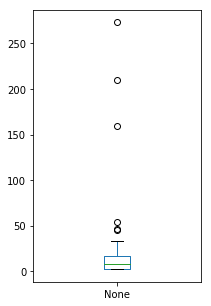

In [17]:
%matplotlib inline
tags_count[tags_count>1].plot(kind='box', figsize=(3,5))

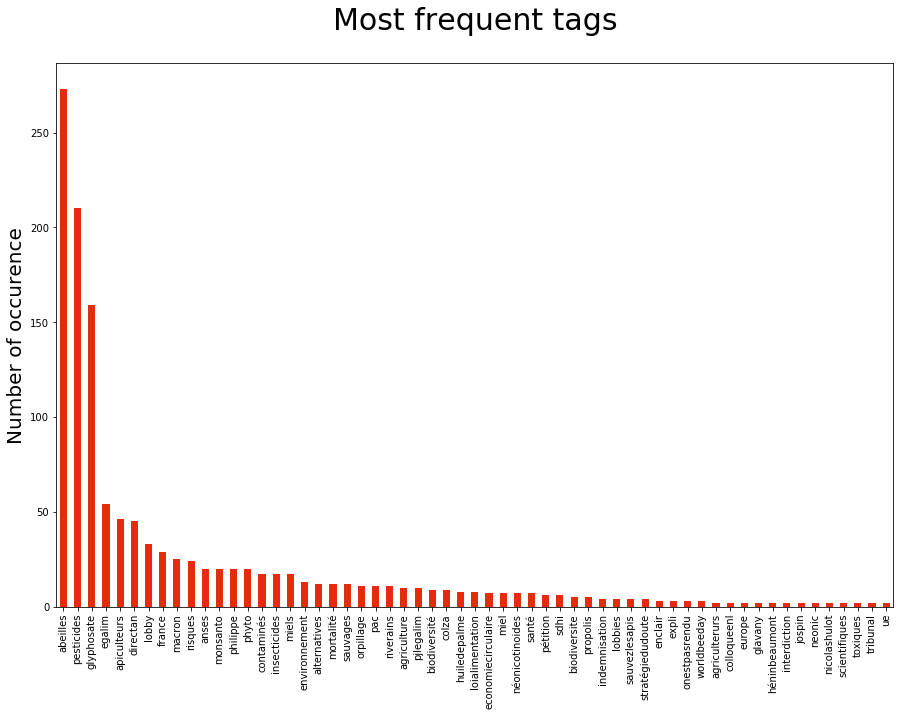

In [18]:
#%matplotlib inline
fig, ax = plt.subplots()
plt.title("Most frequent tags",size=30, y=1.05)
#plt.xlabel('tags',size=15)
plt.ylabel("Number of occurence",size=20)

#for readability we only draw the most present tags
tags_count[tags_count>=2].plot(kind='bar', figsize=(15,10), fontsize=10, color='#e42b0b')

### Explore users

In [19]:
#Explore users
rows=c.execute('''SELECT users.name, count(*) 
                    FROM users, statuses
                    WHERE statuses.user_id==users.id
                    GROUP BY users.id
                    ORDER BY count(*) DESC''').fetchall()

In [20]:
i=[r[0]for r in rows]
d=[r[1]for r in rows]
users_count=pd.Series(d,i)
users_count[:10]

Thiloup🌱             8
Laurent Potelle      6
RedFrog              5
Hubert MESSMER       5
MONICA VADROT        5
Alima Marie          5
Anses                5
Kräuter | Verbena    5
Ferme du pré 🚜🌻🐝     5
APE                  4
dtype: int64

In [21]:
users_count.describe()
#Most users sent only once about ega

count    1214.000000
mean        1.210049
std         0.623421
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
dtype: float64

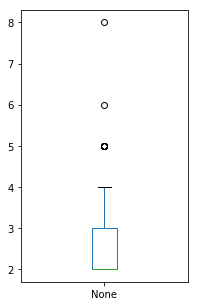

In [22]:
%matplotlib inline
users_count[users_count>1].plot(kind='box', figsize=(3,5))

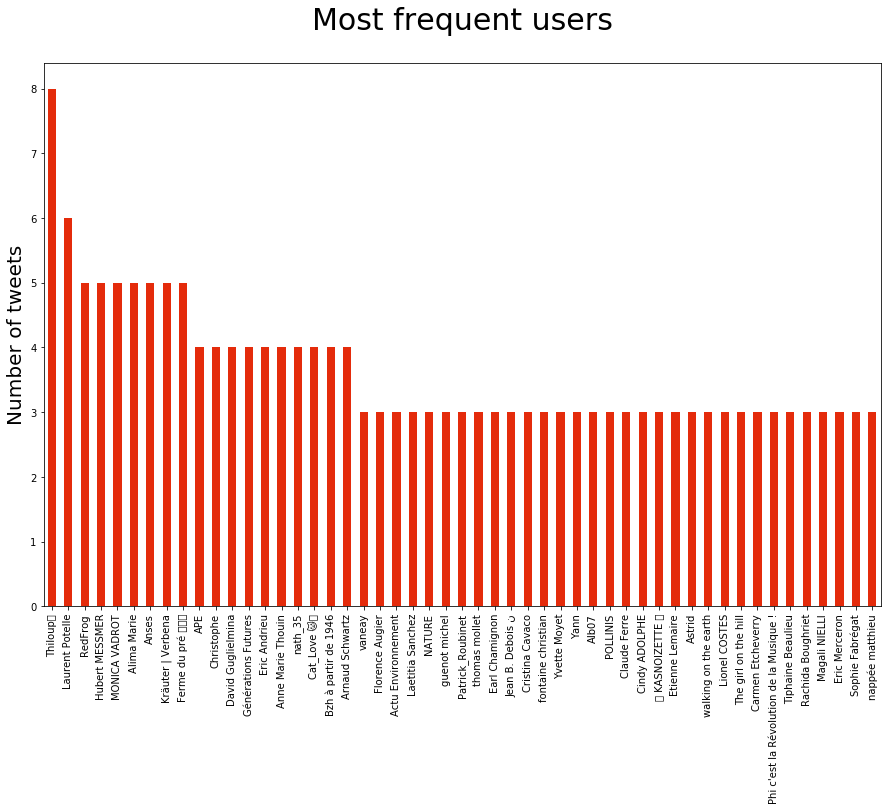

In [25]:
#%matplotlib inline
fig, ax = plt.subplots()
plt.title("Most frequent users",size=30, y=1.05)
#plt.xlabel('tags',size=15)
plt.ylabel("Number of tweets",size=20)

#for readability we only draw the most present tags
users_count[users_count>2].plot(kind='bar', figsize=(15,10), fontsize=10, color='#e42b0b')

### Coocurence of tags in statuses

In [26]:
rows=c.execute('''SELECT statuses.id, tags.htg
                    FROM statuses, tags
                    WHERE statuses.retweeted_status_id is NULL
                    AND statuses.id = tags.status_id
                    AND statuses.lang='fr' ''').fetchall()

!!!! It may be more efficient to create the whole status dictionnary with a first query and to fill it then with a secong query : it avoid the if testing for each occurence... 

In [27]:
# Building of a dictionnary of statuses and tags
d={}
for r in rows :
    if r[0] in d :
        #If the status already in the dictionary, affect 1 to the value correstponding to the tag
        d[r[0]][r[1]]=1
    else : 
        #Else, create a dictionnary for the status and affect 1 to the tag
        d[r[0]]={r[1]:1} 

In [28]:
#Building the data frame
df=pd.DataFrame(list(d.values()),d.keys())
df[df.isnull()]=0
df[:100]

,abeille,abeilles,afp,agriculterurs,agriculture,alimentation,alternatives,anses,biodiversite,biodiversité,...,rt,santé,scientifiques,sdhi,total,toxiques,tribunal,ue,wallonie,énergie
1000757519248113664,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001891540275466240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001890915630411776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001881594683121667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001853357999509510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001851297937612800,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001851198562062336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001850993959718918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001850791257395200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001849635193974784,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#Co-occurence matrix
coocc=df.T.dot(df)
coocc[:100][:100]

,abeille,abeilles,afp,agriculterurs,agriculture,alimentation,alternatives,anses,biodiversite,biodiversité,...,rt,santé,scientifiques,sdhi,total,toxiques,tribunal,ue,wallonie,énergie
abeille,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
abeilles,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
afp,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
agriculterurs,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
agriculture,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alimentation,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alternatives,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
biodiversite,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
biodiversité,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#Sorting the matrix by the number of occurence (diagonal)
coocc['order']=np.diagonal(coocc)
coocc=coocc.sort_values(axis=0, by='order', ascending=False  )
coocc=coocc.append(coocc.pop('order'))
coocc=coocc.sort_values(axis=1, by='order', ascending=False  )
coocc=coocc.drop('order', axis=0)
coocc

,néonicotinoïdes,glyphosate,abeilles,neonicotinoides,pesticides,egalim,phyto,agriculture,directan,alternatives,...,justintrudeau,le79inter,lmef,lobby,loialim,loialimentation,législation,makeourplanetgreatagain,miel,énergie
néonicotinoïdes,72.0,7.0,9.0,0.0,8.0,1.0,5.0,2.0,0.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
glyphosate,7.0,19.0,1.0,3.0,6.0,4.0,6.0,3.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abeilles,9.0,1.0,18.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
neonicotinoides,0.0,3.0,1.0,16.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
pesticides,8.0,6.0,4.0,2.0,15.0,4.0,6.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
egalim,1.0,4.0,0.0,0.0,4.0,9.0,3.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
phyto,5.0,6.0,0.0,0.0,6.0,3.0,8.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
agriculture,2.0,3.0,0.0,0.0,3.0,3.0,5.0,6.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
directan,0.0,1.0,0.0,2.0,0.0,4.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
alternatives,5.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#Percentage of cooccurence
(coocc/np.diagonal(coocc)*100).T

,néonicotinoïdes,glyphosate,abeilles,neonicotinoides,pesticides,egalim,phyto,agriculture,directan,alternatives,...,justintrudeau,le79inter,lmef,lobby,loialim,loialimentation,législation,makeourplanetgreatagain,miel,énergie
néonicotinoïdes,100.000000,9.722222,12.500000,0.000000,11.111111,1.388889,6.944444,2.777778,0.000000,6.944444,...,0.0,0.000000,1.388889,0.0,0.000000,0.000000,1.388889,0.0,0.000000,1.388889
glyphosate,36.842105,100.000000,5.263158,15.789474,31.578947,21.052632,31.578947,15.789474,5.263158,0.000000,...,0.0,5.263158,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
abeilles,50.000000,5.555556,100.000000,5.555556,22.222222,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,5.555556,0.000000
neonicotinoides,0.000000,18.750000,6.250000,100.000000,12.500000,0.000000,0.000000,0.000000,12.500000,0.000000,...,0.0,0.000000,0.000000,0.0,6.250000,6.250000,0.000000,0.0,0.000000,0.000000
pesticides,53.333333,40.000000,26.666667,13.333333,100.000000,26.666667,40.000000,20.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
egalim,11.111111,44.444444,0.000000,0.000000,44.444444,100.000000,33.333333,33.333333,44.444444,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
phyto,62.500000,75.000000,0.000000,0.000000,75.000000,37.500000,100.000000,62.500000,0.000000,25.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
agriculture,33.333333,50.000000,0.000000,0.000000,50.000000,50.000000,83.333333,100.000000,0.000000,33.333333,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
directan,0.000000,16.666667,0.000000,33.333333,0.000000,66.666667,0.000000,0.000000,100.000000,0.000000,...,0.0,0.000000,0.000000,0.0,16.666667,16.666667,0.000000,0.0,0.000000,0.000000
alternatives,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,40.000000,0.000000,100.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


### Coocurence of tags in users and of users in tags

In [32]:
rows=c.execute('''SELECT users.name, tags.htg
                    FROM statuses, tags, users
                    WHERE statuses.id = tags.status_id
                    AND statuses.user_id=users.id
                    ''').fetchall()
#                    AND statuses.lang='fr'


In [33]:
# Building of a dictionnary of statuses and tags
d={}
for r in rows :
    if r[0] in d :
        #If the user already in the dictionary,
        if r[1] in d[r[0]]:
            #... if the tag exist we add one to the count
            d[r[0]][r[1]]+=1
        else:
            #... if the tag do not exist, we create it
            d[r[0]][r[1]]=1
    else : 
        #Else, create a dictionnary for the status and affect 1 to the tag
        d[r[0]]={r[1]:1} 

In [34]:
#fill th null values
df=pd.DataFrame(list(d.values()),d.keys())
df[df.isnull()]=0 # Fonction fill null????????
df.shape

(1049, 92)

In [35]:
#Binarisation of the matrix
df=(df>0)*1

In [36]:
df

,abeille,abeilles,afp,agriculterurs,agriculture,agronomie,alimentation,alternatives,anses,apiculteurs,...,scientifiques,sdhi,stratégiedudoute,total,toxiques,tribunal,ue,wallonie,worldbeeday,énergie
Elise Flore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HOMPS JORDAN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Agence France-Presse,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Patrick Dupriez,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Emmanuelle Cosse,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sir Emmanuel (YVON),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cindy ADOLPHE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
La Vie Agricole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alima Marie,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
La France Agricole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#Co-occurence matrix for tags
coocc=df.T.dot(df)
coocc

,abeille,abeilles,afp,agriculterurs,agriculture,agronomie,alimentation,alternatives,anses,apiculteurs,...,scientifiques,sdhi,stratégiedudoute,total,toxiques,tribunal,ue,wallonie,worldbeeday,énergie
abeille,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
abeilles,0,251,0,2,0,0,0,1,0,39,...,0,0,0,1,0,0,0,0,1,0
afp,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agriculterurs,0,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agriculture,0,0,0,0,8,1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
agronomie,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alimentation,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alternatives,0,1,0,0,3,0,0,9,1,0,...,0,0,0,0,0,0,0,0,0,0
anses,0,0,0,0,0,0,0,1,18,0,...,0,0,0,0,0,0,0,0,0,0
apiculteurs,0,39,0,0,0,0,0,0,0,46,...,0,0,0,0,0,0,0,0,0,0


In [38]:
coocc['order']=np.diagonal(coocc)
coocc=coocc.sort_values(axis=0, by='order', ascending=False  )
coocc=coocc.append(coocc.pop('order'))
coocc=coocc.sort_values(axis=1, by='order', ascending=False  )
coocc=coocc.drop('order', axis=0)
coocc

,néonicotinoïdes,neonicotinoides,abeilles,pesticides,glyphosate,neonicotinoïdes,apiculteurs,egalim,directan,lobby,...,héninbeaumont,invalides,justintrudeau,le79inter,lmef,loialim,makeourplanetgreatagain,minet,ontario,énergie
néonicotinoïdes,500,34,217,160,118,13,40,16,6,1,...,1,0,0,0,1,0,0,0,0,1
neonicotinoides,34,386,20,16,9,5,4,2,9,7,...,0,0,0,0,0,1,0,0,0,0
abeilles,217,20,251,149,14,11,39,2,1,1,...,0,0,0,0,0,0,0,1,0,0
pesticides,160,16,149,188,13,12,0,15,5,1,...,0,0,0,0,0,0,0,0,0,0
glyphosate,118,9,14,13,149,0,4,11,2,0,...,0,0,0,1,0,0,0,0,0,0
neonicotinoïdes,13,5,11,12,0,68,0,31,29,1,...,0,0,0,0,0,0,0,0,0,0
apiculteurs,40,4,39,0,4,0,46,0,0,0,...,0,1,0,0,0,0,0,0,0,0
egalim,16,2,2,15,11,31,0,46,32,1,...,0,0,0,0,0,0,0,0,0,0
directan,6,9,1,5,2,29,0,32,40,1,...,0,0,0,0,0,1,0,0,0,0
lobby,1,7,1,1,0,1,0,1,1,33,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#Percentage of cooccurence
(coocc/np.diagonal(coocc)*100).T

,néonicotinoïdes,neonicotinoides,abeilles,pesticides,glyphosate,neonicotinoïdes,apiculteurs,egalim,directan,lobby,...,héninbeaumont,invalides,justintrudeau,le79inter,lmef,loialim,makeourplanetgreatagain,minet,ontario,énergie
néonicotinoïdes,100.000000,6.800000,43.400000,32.000000,23.600000,2.600000,8.000000,3.200000,1.200000,0.200000,...,0.2,0.000000,0.0,0.000000,0.200000,0.000000,0.0,0.000000,0.0,0.200000
neonicotinoides,8.808290,100.000000,5.181347,4.145078,2.331606,1.295337,1.036269,0.518135,2.331606,1.813472,...,0.0,0.000000,0.0,0.000000,0.000000,0.259067,0.0,0.000000,0.0,0.000000
abeilles,86.454183,7.968127,100.000000,59.362550,5.577689,4.382470,15.537849,0.796813,0.398406,0.398406,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.398406,0.0,0.000000
pesticides,85.106383,8.510638,79.255319,100.000000,6.914894,6.382979,0.000000,7.978723,2.659574,0.531915,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
glyphosate,79.194631,6.040268,9.395973,8.724832,100.000000,0.000000,2.684564,7.382550,1.342282,0.000000,...,0.0,0.000000,0.0,0.671141,0.000000,0.000000,0.0,0.000000,0.0,0.000000
neonicotinoïdes,19.117647,7.352941,16.176471,17.647059,0.000000,100.000000,0.000000,45.588235,42.647059,1.470588,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
apiculteurs,86.956522,8.695652,84.782609,0.000000,8.695652,0.000000,100.000000,0.000000,0.000000,0.000000,...,0.0,2.173913,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
egalim,34.782609,4.347826,4.347826,32.608696,23.913043,67.391304,0.000000,100.000000,69.565217,2.173913,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
directan,15.000000,22.500000,2.500000,12.500000,5.000000,72.500000,0.000000,80.000000,100.000000,2.500000,...,0.0,0.000000,0.0,0.000000,0.000000,2.500000,0.0,0.000000,0.0,0.000000
lobby,3.030303,21.212121,3.030303,3.030303,0.000000,3.030303,0.000000,3.030303,3.030303,100.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [40]:
#Co-occurence matrix for users
coocc=df.dot(df.T)
coocc[:100][:100]

,Elise Flore,HOMPS JORDAN,Agence France-Presse,Patrick Dupriez,Emmanuelle Cosse,Sir Emmanuel (YVON),Cindy ADOLPHE,La Vie Agricole,Alima Marie,La France Agricole,...,JeSuisLaFachosphère,Stéphane CARRIER,Emmanuel Ferrand,Dumez Thierry,Baurain Jean-Claude,Environnement-et-Energie.fr,LINO,DumDum,BIGUERD GHYSLAINE,Nallely P.
Elise Flore,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HOMPS JORDAN,0,2,0,1,1,1,1,1,1,1,...,2,2,2,2,0,1,2,2,1,1
Agence France-Presse,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Patrick Dupriez,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Emmanuelle Cosse,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Sir Emmanuel (YVON),0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Cindy ADOLPHE,1,1,0,1,1,1,5,1,1,1,...,1,1,1,1,0,1,1,1,1,1
La Vie Agricole,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Alima Marie,0,1,0,1,1,1,1,1,5,1,...,1,1,1,1,0,2,1,1,1,1
La France Agricole,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


In [41]:
coocc['order']=np.diagonal(coocc)
coocc=coocc.sort_values(axis=0, by='order', ascending=False  )
coocc=coocc.append(coocc.pop('order'))
coocc=coocc.sort_values(axis=1, by='order', ascending=False  )
coocc=coocc.drop('order', axis=0)
coocc

,Thiloup🌱,MONICA VADROT,David Guglielmina,Sophie Fabrégat,Kräuter | Verbena,Bzh à partir de 1946,Lionne verte🐝🕊🐋,Philippe dit fifi,Rachida Boughriet,gabriel,...,COURTOIS,Isabelle BR,Secrétariat FLAC,Isabelle,Jean-Baptiste Rozier,fllx2fllx,PILORE,lemonpas,Hakimo,Philip robert B.
Thiloup🌱,9,4,4,4,2,1,3,3,3,3,...,1,1,1,1,0,1,1,1,1,1
MONICA VADROT,4,9,3,3,2,1,2,3,3,3,...,1,1,1,1,1,1,1,1,1,1
David Guglielmina,4,3,8,8,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
Sophie Fabrégat,4,3,8,8,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
Kräuter | Verbena,2,2,1,1,8,2,5,2,1,2,...,0,0,0,0,0,0,0,0,0,0
Bzh à partir de 1946,1,1,0,0,2,8,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Lionne verte🐝🕊🐋,3,2,2,2,5,1,8,2,2,2,...,0,0,0,0,0,0,0,0,0,0
Philippe dit fifi,3,3,2,2,2,1,2,7,2,7,...,0,0,0,0,0,0,0,0,0,0
Rachida Boughriet,3,3,7,7,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
gabriel,3,3,2,2,2,1,2,7,2,7,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#Percentage of cooccurence
(coocc/np.diagonal(coocc)*100).T

,Thiloup🌱,MONICA VADROT,David Guglielmina,Sophie Fabrégat,Kräuter | Verbena,Bzh à partir de 1946,Lionne verte🐝🕊🐋,Philippe dit fifi,Rachida Boughriet,gabriel,...,COURTOIS,Isabelle BR,Secrétariat FLAC,Isabelle,Jean-Baptiste Rozier,fllx2fllx,PILORE,lemonpas,Hakimo,Philip robert B.
Thiloup🌱,100.000000,44.444444,44.444444,44.444444,22.222222,11.111111,33.333333,33.333333,33.333333,33.333333,...,11.111111,11.111111,11.111111,11.111111,0.000000,11.111111,11.111111,11.111111,11.111111,11.111111
MONICA VADROT,44.444444,100.000000,33.333333,33.333333,22.222222,11.111111,22.222222,33.333333,33.333333,33.333333,...,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111,11.111111
David Guglielmina,50.000000,37.500000,100.000000,100.000000,12.500000,0.000000,25.000000,25.000000,87.500000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sophie Fabrégat,50.000000,37.500000,100.000000,100.000000,12.500000,0.000000,25.000000,25.000000,87.500000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kräuter | Verbena,25.000000,25.000000,12.500000,12.500000,100.000000,25.000000,62.500000,25.000000,12.500000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bzh à partir de 1946,12.500000,12.500000,0.000000,0.000000,25.000000,100.000000,12.500000,12.500000,0.000000,12.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Lionne verte🐝🕊🐋,37.500000,25.000000,25.000000,25.000000,62.500000,12.500000,100.000000,25.000000,25.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Philippe dit fifi,42.857143,42.857143,28.571429,28.571429,28.571429,14.285714,28.571429,100.000000,28.571429,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rachida Boughriet,42.857143,42.857143,100.000000,100.000000,14.285714,0.000000,28.571429,28.571429,100.000000,28.571429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gabriel,42.857143,42.857143,28.571429,28.571429,28.571429,14.285714,28.571429,100.000000,28.571429,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


!!!! Il vaudrait mieux creer un vecteur ordonné et trier la matrice avant la coocurence => beaucoup moins lourd...

# the #ega, #egalim, '#egalimentation', and '#EtatsGenerauxdelAlimentation' artificialy increase the co-occurence matrix
del df['ega']
del df['egalim']
del df['egalimentation']
del df['etatsgenerauxdelalimentation']

In [48]:
#Co-occurence matrix for users
coocc=df.dot(df.T)
coocc[50:100][:60]

,Elise Flore,HOMPS JORDAN,Agence France-Presse,Patrick Dupriez,Emmanuelle Cosse,Sir Emmanuel (YVON),Cindy ADOLPHE,La Vie Agricole,Alima Marie,La France Agricole,...,JeSuisLaFachosphère,Stéphane CARRIER,Emmanuel Ferrand,Dumez Thierry,Baurain Jean-Claude,Environnement-et-Energie.fr,LINO,DumDum,BIGUERD GHYSLAINE,Nallely P.
Octavius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Olivier Ferrari,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
L'écho circulaire,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Les Verts Lausannois,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Longuefosse,0,2,0,1,1,1,1,1,1,1,...,2,2,2,2,0,1,2,2,1,1
Vincent Rossi,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Pat à trac,1,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chevalley Bernard,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Luc-Olivier Erard,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
Anne Berguerand,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


In [49]:
coocc['order']=np.diagonal(coocc)
coocc=coocc.sort_values(axis=0, by='order', ascending=False  )
coocc=coocc.append(coocc.pop('order'))
coocc=coocc.sort_values(axis=1, by='order', ascending=False  )
coocc=coocc.drop('order', axis=0)
coocc[:100]

,Thiloup🌱,MONICA VADROT,David Guglielmina,Sophie Fabrégat,Kräuter | Verbena,Bzh à partir de 1946,Lionne verte🐝🕊🐋,Philippe dit fifi,Rachida Boughriet,gabriel,...,COURTOIS,Isabelle BR,Secrétariat FLAC,Isabelle,Jean-Baptiste Rozier,fllx2fllx,PILORE,lemonpas,Hakimo,Philip robert B.
Thiloup🌱,9,4,4,4,2,1,3,3,3,3,...,1,1,1,1,0,1,1,1,1,1
MONICA VADROT,4,9,3,3,2,1,2,3,3,3,...,1,1,1,1,1,1,1,1,1,1
David Guglielmina,4,3,8,8,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
Sophie Fabrégat,4,3,8,8,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
Kräuter | Verbena,2,2,1,1,8,2,5,2,1,2,...,0,0,0,0,0,0,0,0,0,0
Bzh à partir de 1946,1,1,0,0,2,8,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Lionne verte🐝🕊🐋,3,2,2,2,5,1,8,2,2,2,...,0,0,0,0,0,0,0,0,0,0
Philippe dit fifi,3,3,2,2,2,1,2,7,2,7,...,0,0,0,0,0,0,0,0,0,0
Rachida Boughriet,3,3,7,7,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
gabriel,3,3,2,2,2,1,2,7,2,7,...,0,0,0,0,0,0,0,0,0,0


In [50]:
coocc[:50]

,Thiloup🌱,MONICA VADROT,David Guglielmina,Sophie Fabrégat,Kräuter | Verbena,Bzh à partir de 1946,Lionne verte🐝🕊🐋,Philippe dit fifi,Rachida Boughriet,gabriel,...,COURTOIS,Isabelle BR,Secrétariat FLAC,Isabelle,Jean-Baptiste Rozier,fllx2fllx,PILORE,lemonpas,Hakimo,Philip robert B.
Thiloup🌱,9,4,4,4,2,1,3,3,3,3,...,1,1,1,1,0,1,1,1,1,1
MONICA VADROT,4,9,3,3,2,1,2,3,3,3,...,1,1,1,1,1,1,1,1,1,1
David Guglielmina,4,3,8,8,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
Sophie Fabrégat,4,3,8,8,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
Kräuter | Verbena,2,2,1,1,8,2,5,2,1,2,...,0,0,0,0,0,0,0,0,0,0
Bzh à partir de 1946,1,1,0,0,2,8,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Lionne verte🐝🕊🐋,3,2,2,2,5,1,8,2,2,2,...,0,0,0,0,0,0,0,0,0,0
Philippe dit fifi,3,3,2,2,2,1,2,7,2,7,...,0,0,0,0,0,0,0,0,0,0
Rachida Boughriet,3,3,7,7,1,0,2,2,7,2,...,0,0,0,0,0,0,0,0,0,0
gabriel,3,3,2,2,2,1,2,7,2,7,...,0,0,0,0,0,0,0,0,0,0


In [51]:
coocc.sort_values(by='La FNSEA', ascending=True)['La FNSEA']

KeyError: 'La FNSEA'

In [52]:
coocc['Carmen Etcheverry']

Thiloup🌱                      1
MONICA VADROT                 2
David Guglielmina             0
Sophie Fabrégat               0
Kräuter | Verbena             0
Bzh à partir de 1946          0
Lionne verte🐝🕊🐋               0
Philippe dit fifi             0
Rachida Boughriet             0
gabriel                       0
Mick@91                       0
Actu Environnement            0
Tinemar                       0
Current75                     0
The Lady is a Tramp           0
Ré-Sidoruk Lucie              0
nappée matthieu               1
Patrick_Roubinet              0
⚓️ CHIEF RED CLOUD ⚓️ 🤘       0
Alb07                         1
Joyce Alessandria             0
Yann                          0
⚓Bruno_Laurent DeFrance_🌐🐾    0
Cristo φ                      1
News politiques               0
Astrid                        1
Zaza Dwazizi                  1
RedFrog                       1
FUMERY Denis                  0
pascale cioli                 1
                             ..
EdmondFr

# Users Clustering using K-means
We will perform k-means clustering of users based on the use of the most frequent tags

### Select features of interest (most frequent)

In [45]:
features=list(tags_count[tags_count>=250].index)

In [46]:
select_df=df[features]

### Scale the Features using StandardScaler

In [47]:
X = StandardScaler().fit_transform(select_df)

ValueError: Found array with 0 feature(s) (shape=(894, 0)) while a minimum of 1 is required by StandardScaler.

### Use k-Means Clustering

In [48]:
kmeans = KMeans(n_clusters=8)
model = kmeans.fit(X)
print("model\n", model)

NameError: name 'X' is not defined

### Clustering results

In [49]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [50]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k','orange','grey','pink']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-1,+10])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [51]:
centers = model.cluster_centers_
P = pd_centers(features, centers)
P

NameError: name 'model' is not defined

In [52]:
parallel_plot(P)

NameError: name 'P' is not defined

- K-means faire un cluster des htgs les plus courants (peut-être sur les user les plus prolifiques)
- faire un cluster des user prolifiques par les htgs les plus courants.

- Creer une matrice de lien entre les comptes (qui site qui, qui retweet qui...)
- Essayer de prédire le lien par la coocurence des user dans les twit (dans les mots complet?)
- analyse du texte des tweet?
- Creer des graphs


In [53]:
print(set(stopwords.words('french')))

NameError: name 'stopwords' is not defined